# **Krystal Nguyen - 223212228 - SIT307**












# I. Reproduce Reported Results

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

## Load Data and PreProcessing

In [40]:
# Load and preprocess the data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, header=None, names=columns)

biologically_inconceivable_columns = ['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in biologically_inconceivable_columns:
    data[col] = data[col].replace(0, np.nan)
    data[col].fillna(data[col].median(), inplace=True)

scaler = StandardScaler()
data[biologically_inconceivable_columns] = scaler.fit_transform(data[biologically_inconceivable_columns])

def replace_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        median_value = df[col].median()
        df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = median_value
    return df

data_cleaned = replace_outliers_iqr(data, biologically_inconceivable_columns)

X = data_cleaned.drop('Outcome', axis=1)
y = data_cleaned['Outcome']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)



## Model Training

In [45]:
# Define base models and meta learner
dt = DecisionTreeClassifier(max_depth=2)  # Degrading the performance of DT by restricting depth
rf = RandomForestClassifier()
svm = SVC(probability=True)
meta_learner = LogisticRegression()

# Create stacking classifier
stacking_model = StackingClassifier(
    estimators=[
        ('dt', dt),
        ('rf', rf),
        ('svm', svm)
    ],
    final_estimator=meta_learner
)

# List of models
models = {
    'DT': dt,
    'RF': rf,
    'SVM': svm,
    'Stacking Ensemble': stacking_model
}

# Create a dataframe to store results
results = pd.DataFrame(columns=["Algorithm", "Accuracy", "Precision", "Recall", "F1-Score"])

# Train-Test Results
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results = pd.concat([results, pd.DataFrame({
        "Algorithm": [model_name],
        "Protocol": ["Train-Test"],
        "Accuracy": [round(accuracy * 100, 2)],
        "Precision": [round(precision, 2)],
        "Recall": [round(recall, 2)],
        "F1-Score": [round(f1, 2)]
    })], ignore_index=True)

# Cross-Validation Results
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    # Cross-validation on different metrics
    cv_accuracy = cross_val_score(model, X_resampled, y_resampled, cv=cv, scoring='accuracy').mean()
    cv_precision = cross_val_score(model, X_resampled, y_resampled, cv=cv, scoring='precision').mean()
    cv_recall = cross_val_score(model, X_resampled, y_resampled, cv=cv, scoring='recall').mean()
    cv_f1 = cross_val_score(model, X_resampled, y_resampled, cv=cv, scoring='f1').mean()

    # Append Cross-Validation Results to the DataFrame
    results = pd.concat([results, pd.DataFrame({
        "Algorithm": [model_name],
        "Protocol": ["Cross-Validation"],
        "Accuracy": [round(cv_accuracy * 100, 2)],
        "Precision": [round(cv_precision, 2)],
        "Recall": [round(cv_recall, 2)],
        "F1-Score": [round(cv_f1, 2)]
    })], ignore_index=True)

# Display the results in a tabular format
results.style.set_table_styles([{
    'selector': 'thead th',
    'props': [('font-weight', 'bold')]
}, {
    'selector': 'tbody td',
    'props': [('text-align', 'center')]
}]).hide(axis="index")


Algorithm,Accuracy,Precision,Recall,F1-Score,Protocol
DT,70.330000,0.660000,0.830000,0.740000,Train-Test
RF,78.670000,0.780000,0.810000,0.790000,Train-Test
SVM,72.330000,0.750000,0.680000,0.710000,Train-Test
Stacking Ensemble,77.330000,0.760000,0.800000,0.780000,Train-Test
DT,72.700000,0.810000,0.590000,0.680000,Cross-Validation
RF,80.900000,0.790000,0.840000,0.820000,Cross-Validation
SVM,71.800000,0.730000,0.690000,0.710000,Cross-Validation
Stacking Ensemble,81.600000,0.800000,0.840000,0.830000,Cross-Validation


# II. Design own ML solution

In [ ]:
# Load PIMA Indians Diabetes dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
df  = pd.read_csv(url, header=None, names=columns)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


##EDA

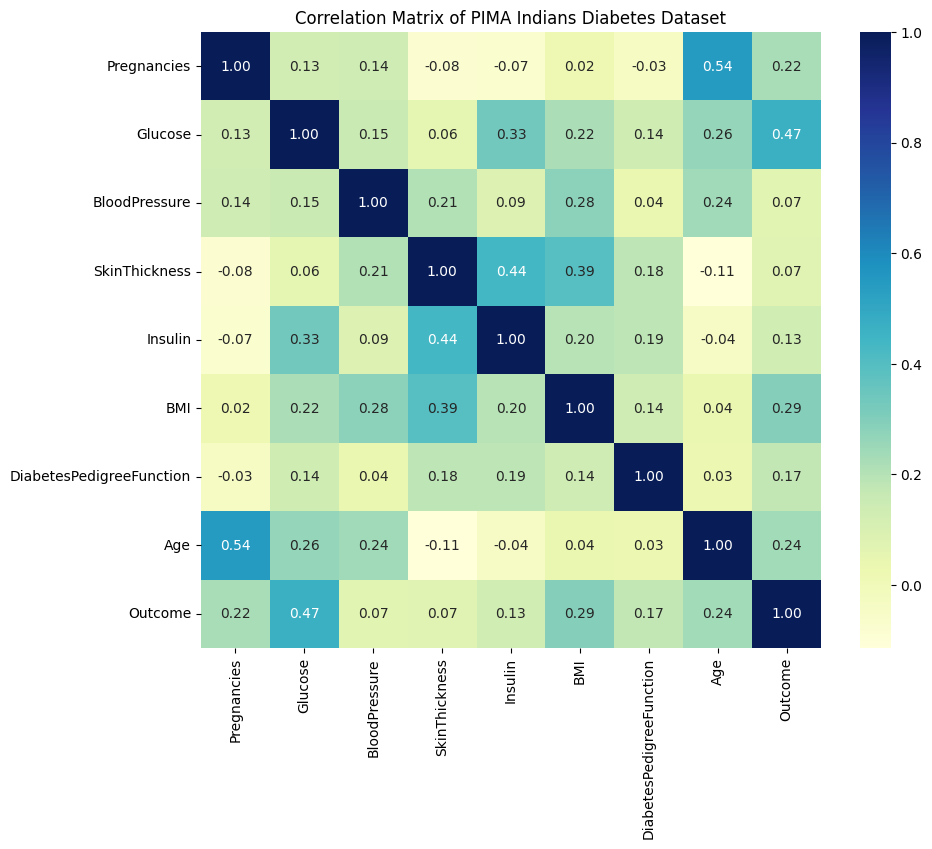

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Correlation Matrix of PIMA Indians Diabetes Dataset')
plt.show()


In [ ]:
!pip install plotly

In [ ]:
df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']] = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']].replace(0, np.NaN)

In [ ]:
df.isnull().sum()

,0
Pregnancies,111
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [ ]:
def median_target(var):
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In [ ]:
columns = df.columns
columns = columns.drop("Outcome")
for i in columns:
    median_target(i)
    df.loc[(df['Outcome'] == 0 ) & (df[i].isnull()), i] = median_target(i)[i][0]
    df.loc[(df['Outcome'] == 1 ) & (df[i].isnull()), i] = median_target(i)[i][1]

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,5.0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [ ]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


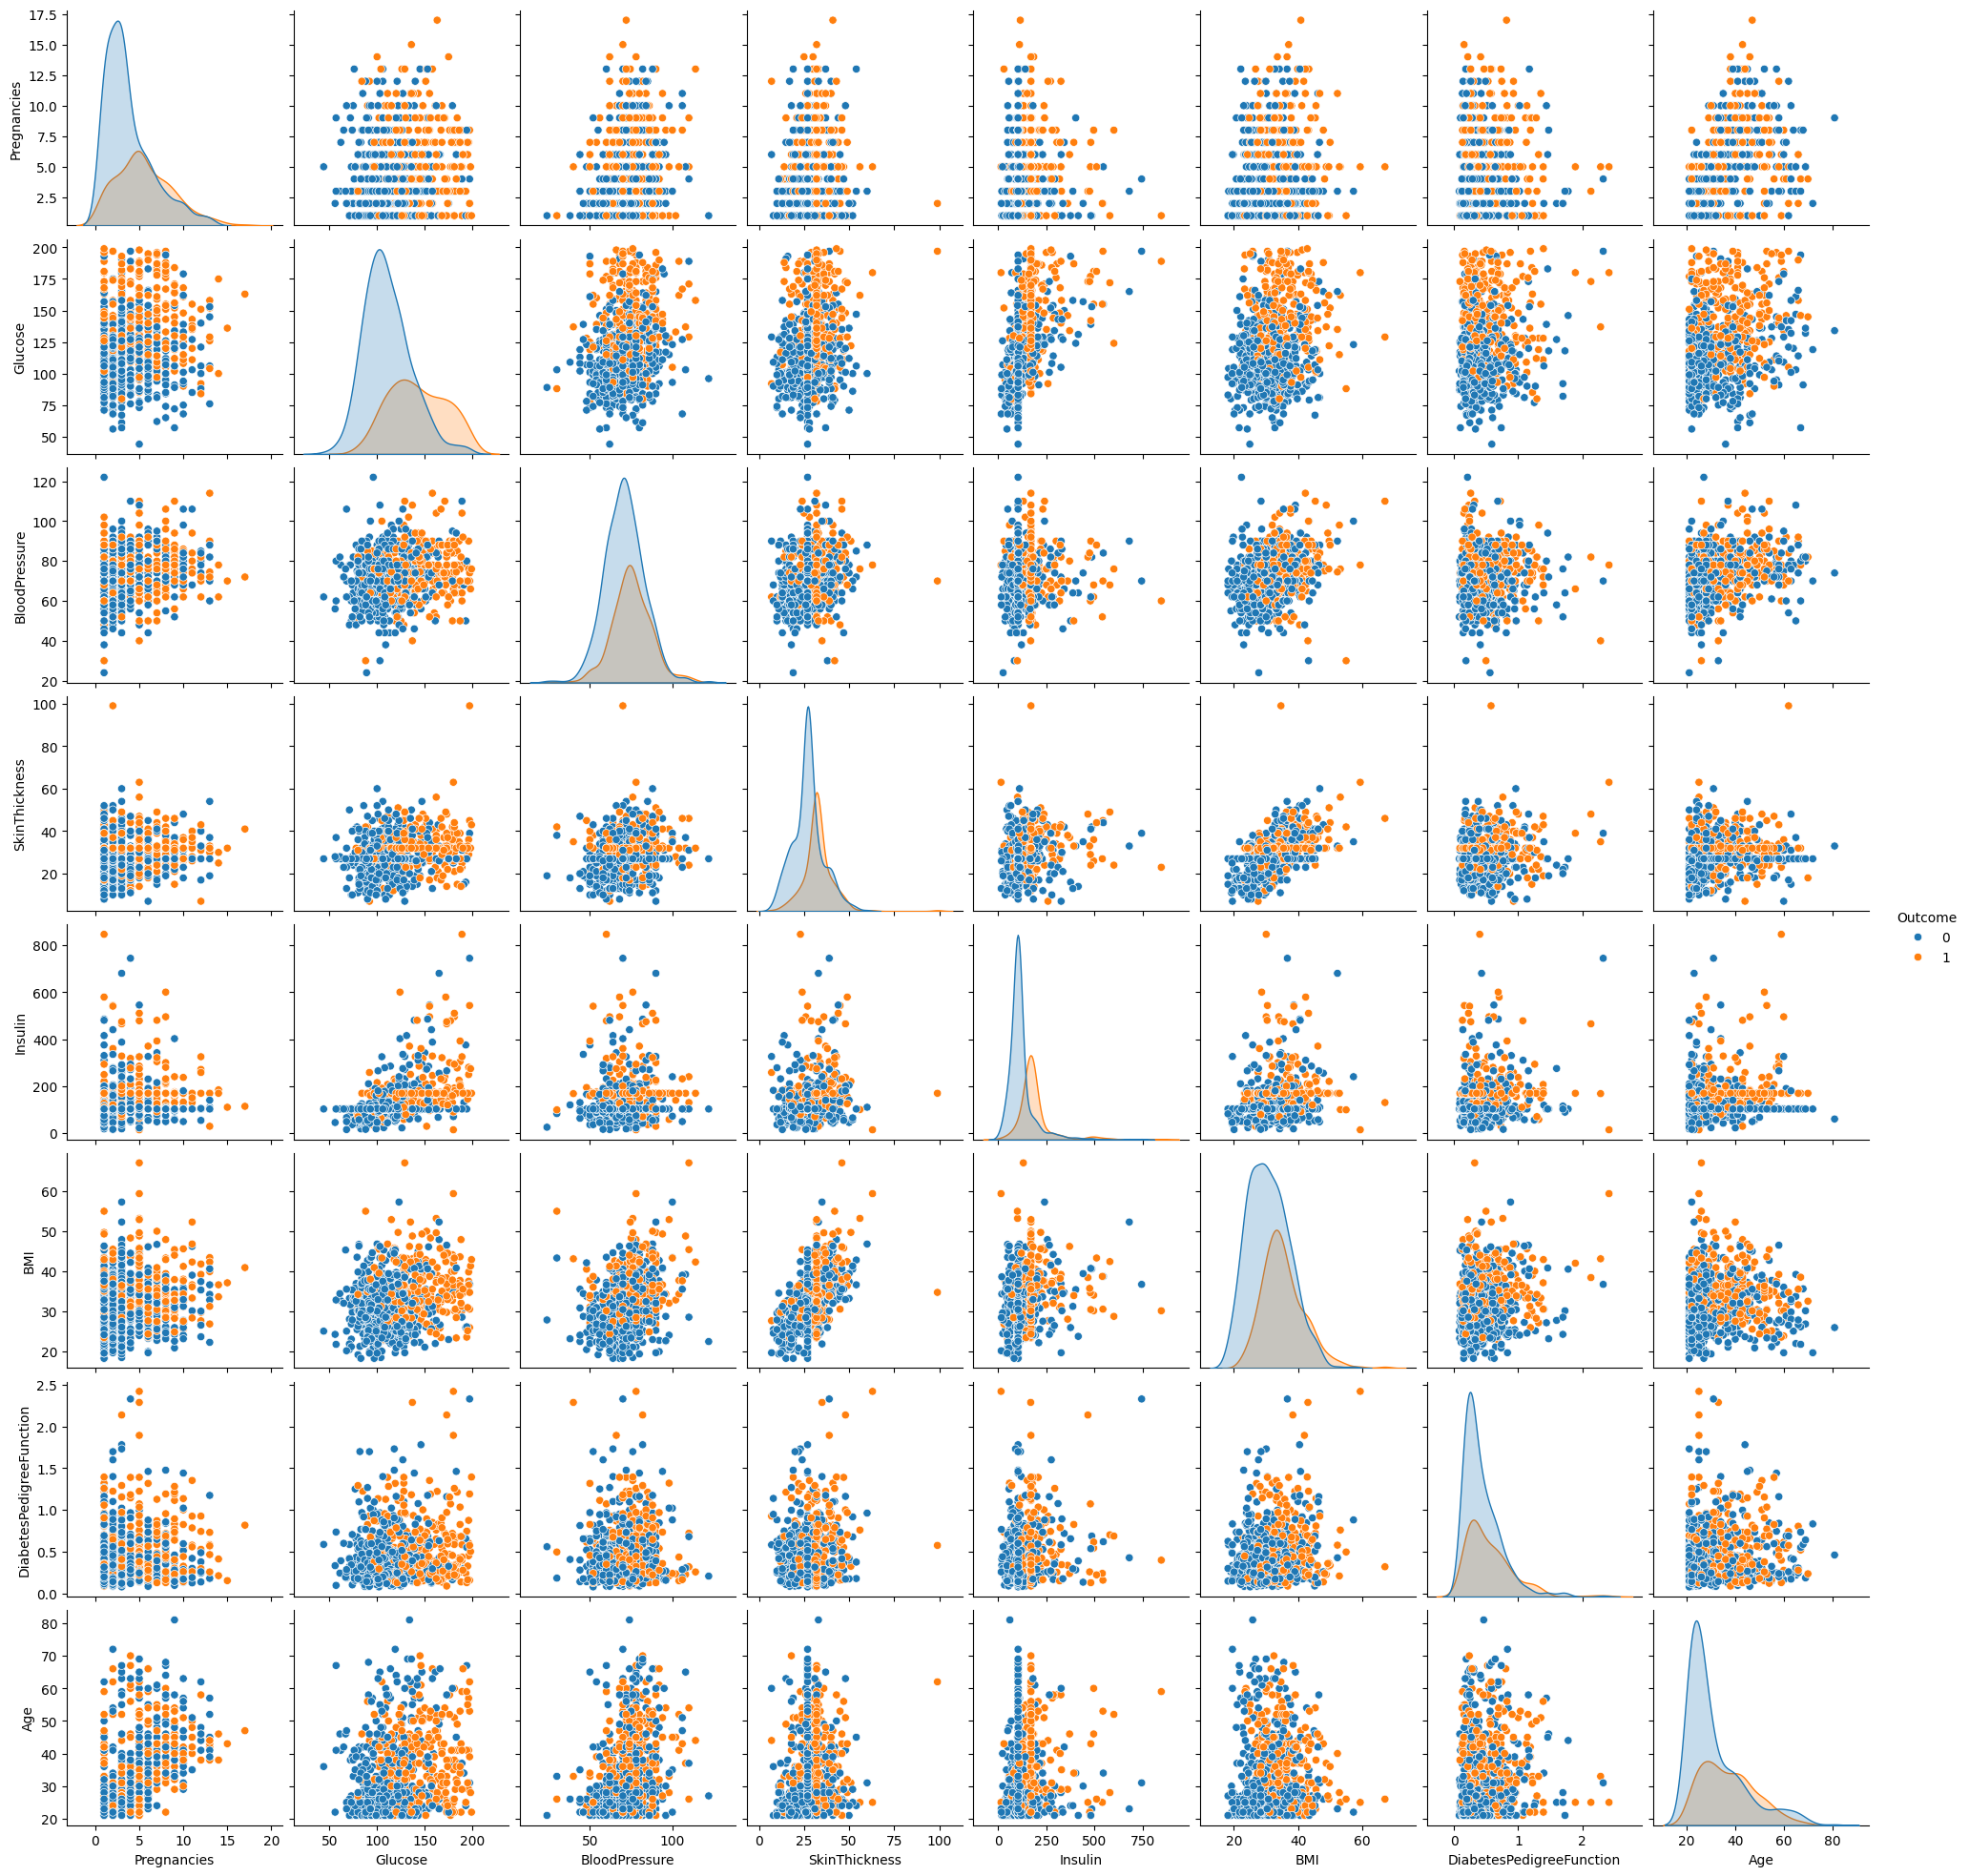

In [ ]:
p = sns.pairplot(df, hue="Outcome")

## Outlier Handling


In [ ]:
for feature in df:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3-Q1
    lower = Q1-1.5*IQR
    upper = Q3+1.5*IQR
    if df[(df[feature]>upper)].any(axis=None):
        print(feature, "yes")
    else:
        print(feature, "no")

Pregnancies yes
Glucose no
BloodPressure yes
SkinThickness yes
Insulin yes
BMI yes
DiabetesPedigreeFunction yes
Age yes
Outcome no


In [ ]:
Q1 = df.Insulin.quantile(0.25)
Q3 = df.Insulin.quantile(0.75)
IQR = Q3-Q1
lower = Q1-1.5*IQR
upper = Q3+1.5*IQR
df.loc[df['Insulin']>upper, "Insulin"] = upper

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=10)
lof.fit_predict(df)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1

<Axes: xlabel='Pregnancies'>

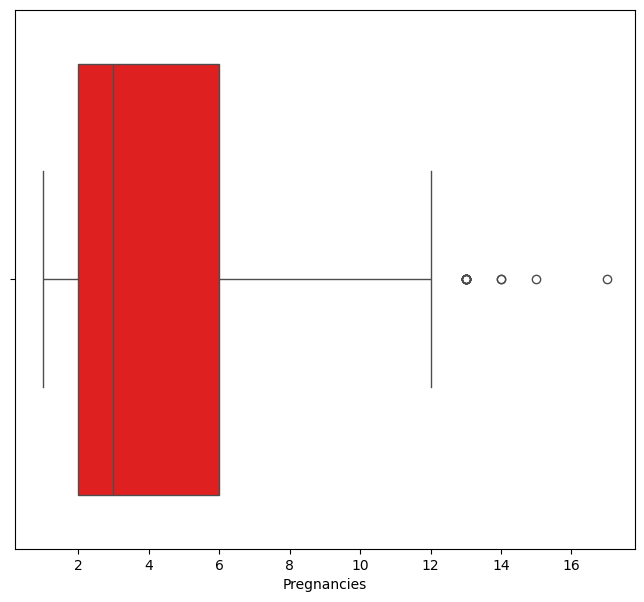

In [ ]:
plt.figure(figsize=(8,7))
sns.boxplot(x= df["Pregnancies"], color="red")

In [ ]:
df_scores = lof.negative_outlier_factor_
np.sort(df_scores)[0:20]

array([-3.06509976, -2.38250393, -2.15557018, -2.11501347, -2.08356175,
       -1.95386655, -1.83559384, -1.74974237, -1.7330214 , -1.71017168,
       -1.70215105, -1.68722889, -1.64294601, -1.64180205, -1.61181746,
       -1.61067772, -1.60925053, -1.60214364, -1.59998552, -1.58761193])

In [ ]:
thresold = np.sort(df_scores)[7]

In [ ]:
outlier = df_scores>thresold
df = df[outlier]

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,5.0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


## Feature Engineering

In [ ]:
# Feature Enginnering
NewBMI = pd.Series(["Underweight","Normal", "Overweight","Obesity 1", "Obesity 2", "Obesity 3"], dtype = "category")

In [ ]:
df['NewBMI'] = NewBMI
df.loc[df["BMI"]<18.5, "NewBMI"] = NewBMI[0]
df.loc[(df["BMI"]>18.5) & df["BMI"]<=24.9, "NewBMI"] = NewBMI[1]
df.loc[(df["BMI"]>24.9) & df["BMI"]<=29.9, "NewBMI"] = NewBMI[2]
df.loc[(df["BMI"]>29.9) & df["BMI"]<=34.9, "NewBMI"] = NewBMI[3]
df.loc[(df["BMI"]>34.9) & df["BMI"]<=39.9, "NewBMI"] = NewBMI[4]
df.loc[df["BMI"]>39.9, "NewBMI"] = NewBMI[5]

In [ ]:
def set_insuline(row):
    if row["Insulin"]>=16 and row["Insulin"]<=166:
        return "Normal"
    else:
        return "Abnormal"

In [ ]:
df = df.assign(NewInsulinScore=df.apply(set_insuline, axis=1))

In [ ]:
# Some intervals were determined according to the glucose variable and these were assigned categorical variables.
NewGlucose = pd.Series(["Low", "Normal", "Overweight", "Secret", "High"], dtype = "category")
df["NewGlucose"] = NewGlucose
df.loc[df["Glucose"] <= 70, "NewGlucose"] = NewGlucose[0]
df.loc[(df["Glucose"] > 70) & (df["Glucose"] <= 99), "NewGlucose"] = NewGlucose[1]
df.loc[(df["Glucose"] > 99) & (df["Glucose"] <= 126), "NewGlucose"] = NewGlucose[2]
df.loc[df["Glucose"] > 126 ,"NewGlucose"] = NewGlucose[3]

In [ ]:
# One hot encoding
df = pd.get_dummies(df, columns = ["NewBMI", "NewInsulinScore", "NewGlucose"], drop_first=True)

In [ ]:
categorical_df = df[['NewBMI_Obesity 1',
       'NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight',
       'NewBMI_Underweight', 'NewInsulinScore_Normal', 'NewGlucose_Low',
       'NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret']]

In [ ]:
y=df['Outcome']
X=df.drop(['Outcome','NewBMI_Obesity 1',
       'NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight',
       'NewBMI_Underweight', 'NewInsulinScore_Normal', 'NewGlucose_Low',
       'NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret'], axis=1)

In [ ]:
cols = X.columns
index = X.index

In [ ]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21
4,5.0,137.0,40.0,35.0,168.0,43.1,2.288,33


In [ ]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X)
X=transformer.transform(X)
X=pd.DataFrame(X, columns = cols, index = index)

In [ ]:
X = pd.concat([X, categorical_df], axis=1)

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [ ]:
X_train, X_test, y_train , y_test = train_test_split(X_resampled,y_resampled, test_size=0.3, random_state=42)

text with minimal data handling

# Model Training

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[120  29]
 [ 18 132]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       149
           1       0.82      0.88      0.85       150

    accuracy                           0.84       299
   macro avg       0.84      0.84      0.84       299
weighted avg       0.84      0.84      0.84       299



### KNN

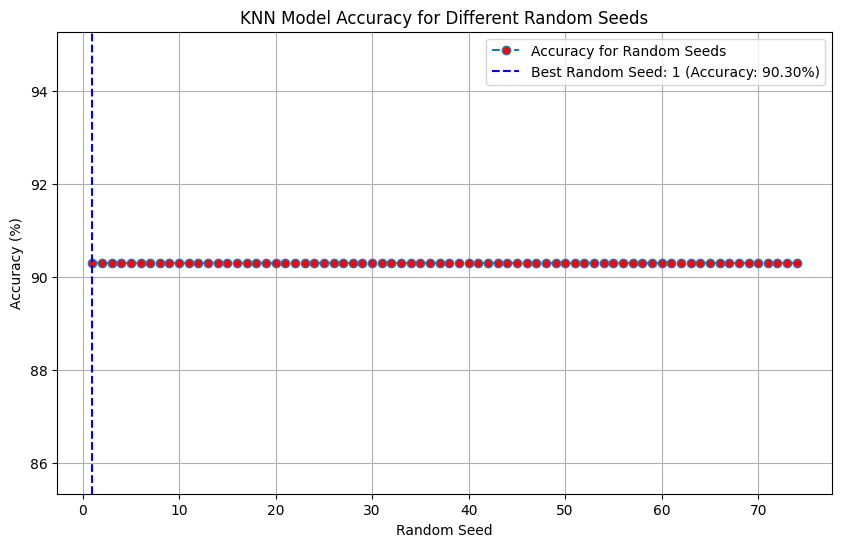

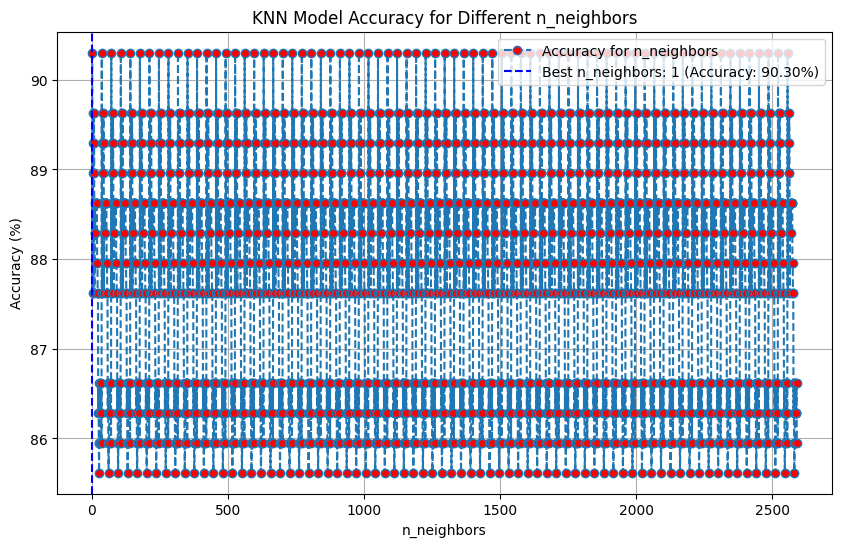

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Assuming x and y are already defined and contain your dataset.
accuracies = []
accuracies2 = []
best_accuracy_seed = 0
best_seed = 1
best_accuracy_neighbors = 0
best_neighbors = 1

for seed in range(1, 75):

    for n_neighbors in range(1, 36):
        knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn_model.fit(X_train, y_train)
        y_pred = knn_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        if accuracy > best_accuracy_neighbors:
            best_accuracy_neighbors = accuracy
            best_neighbors = n_neighbors

        accurate_value = accuracy * 100
        accuracies2.append(accurate_value)

    if best_accuracy_neighbors > best_accuracy_seed:
        best_accuracy_seed = best_accuracy_neighbors
        best_seed = seed

    accuracies.append(best_accuracy_seed * 100)



plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', markerfacecolor='red', linestyle="--", label='Accuracy for Random Seeds')
plt.title('KNN Model Accuracy for Different Random Seeds')
plt.xlabel('Random Seed')
plt.ylabel('Accuracy (%)')
plt.grid()

plt.axvline(x=best_seed, color='blue', linestyle='--', label=f'Best Random Seed: {best_seed} (Accuracy: {best_accuracy_seed * 100:.2f}%)')
plt.legend()
plt.show()


# Ensure appropriate range for n_neighbors
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracies2) + 1), accuracies2, marker='o', markerfacecolor='red', linestyle="--", label='Accuracy for n_neighbors')
plt.title('KNN Model Accuracy for Different n_neighbors')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy (%)')
plt.grid()

plt.axvline(x=best_neighbors, color='blue', linestyle='--', label=f'Best n_neighbors: {best_neighbors} (Accuracy: {best_accuracy_neighbors * 100:.2f}%)')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

### Ensemble

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
# 3. Ensemble Model (Voting Classifier)
def build_dnn():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
class KerasDNNWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        y_categorical = to_categorical(y) if len(np.unique(y)) > 2 else y  # Convert labels if multiclass
        self.model.fit(X, y, epochs=50, batch_size=32, verbose=0)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype(int).flatten()

dnn_wrapper = KerasDNNWrapper(build_dnn())
best_rf = RandomForestClassifier()
# Ensemble using Voting Classifier
ensemble_model = VotingClassifier(estimators=[('dnn', dnn_wrapper), ('rf', best_rf)], voting='hard')
ensemble_model.fit(X_train, y_train)

# Evaluate Ensemble Model
ensemble_predictions = ensemble_model.predict(X_test)
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_predictions))
print("Ensemble Classification Report:\n", classification_report(y_test, ensemble_predictions))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Ensemble Accuracy: 0.9096989966555183
Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       149
           1       0.91      0.91      0.91       150

    accuracy                           0.91       299
   macro avg       0.91      0.91      0.91       299
weighted avg       0.91      0.91      0.91       299



### CatBoost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3,
    border_count=32,
    loss_function='Logloss',
    random_seed=42,
    verbose=False
)

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
}

grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid,
                           scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Train the CatBoost model with the best hyperparameters
best_catboost_model = grid_search.best_estimator_
best_catboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_catboost = best_catboost_model.predict(X_test)

# Evaluate the model
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print("CatBoost Accuracy:", accuracy_catboost)
print("CatBoost Classification Report:\n", classification_report(y_test, y_pred_catboost))


Best Hyperparameters: {'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
CatBoost Accuracy: 0.919732441471572
CatBoost Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       149
           1       0.90      0.94      0.92       150

    accuracy                           0.92       299
   macro avg       0.92      0.92      0.92       299
weighted avg       0.92      0.92      0.92       299



### Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# RandomizedSearchCV for Random Forest
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=rf_param_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
rf_random.fit(X_train, y_train)

best_rf = rf_random.best_estimator_

# Evaluate the best model
evaluate_model(best_rf, X_train, X_test, y_train, y_test)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Train-Test           RandomForestClassifier 92.64   90.00   96.00   92.90


### XGBoost

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
# Define the model

model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.2f}')

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)


Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5573 - loss: 0.7823 - val_accuracy: 0.6978 - val_loss: 0.6498 - learning_rate: 0.0010
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6634 - loss: 0.6489 - val_accuracy: 0.7554 - val_loss: 0.6186 - learning_rate: 0.0010
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7075 - loss: 0.5374 - val_accuracy: 0.7338 - val_loss: 0.5895 - learning_rate: 0.0010
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7237 - loss: 0.5289 - val_accuracy: 0.7482 - val_loss: 0.5621 - learning_rate: 0.0010
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7524 - loss: 0.5377 - val_accuracy: 0.7770 - val_loss: 0.5413 - learning_rate: 0.0010
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8058 - loss: 0.4812 - val_accuracy: 0.7914 - val_loss: 0.5158 - learning_rate: 0.0010
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7767 - loss: 0.4732 - val_ac

In [ ]:
!pip install xgboost

## Model Comparison

Accuracy: [84.28, 85.95, 90.64, 92.31, 91.97]
ROC AUC: [88.31, 92.81, 97.68, 97.94, 97.7]
F1 Scores: [84.26, 85.89, 90.64, 92.30000000000001, 91.97]


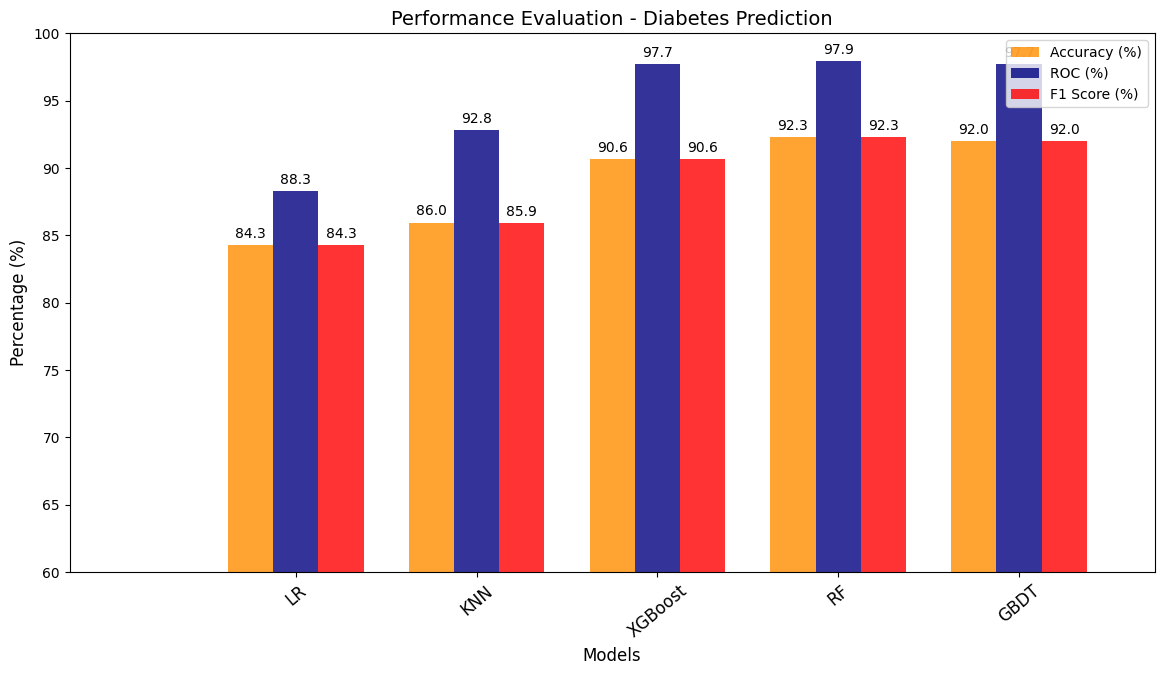

Logistic Regression  ROC AUC: 0.88, F1-Score: 84.26
KNN                  ROC AUC: 0.93, F1-Score: 85.89
Random Forest        ROC AUC: 0.98, F1-Score: 90.96
CatBoost             ROC AUC: 0.98, F1-Score: 91.97
XGBoost              ROC AUC: 0.98, F1-Score: 90.64


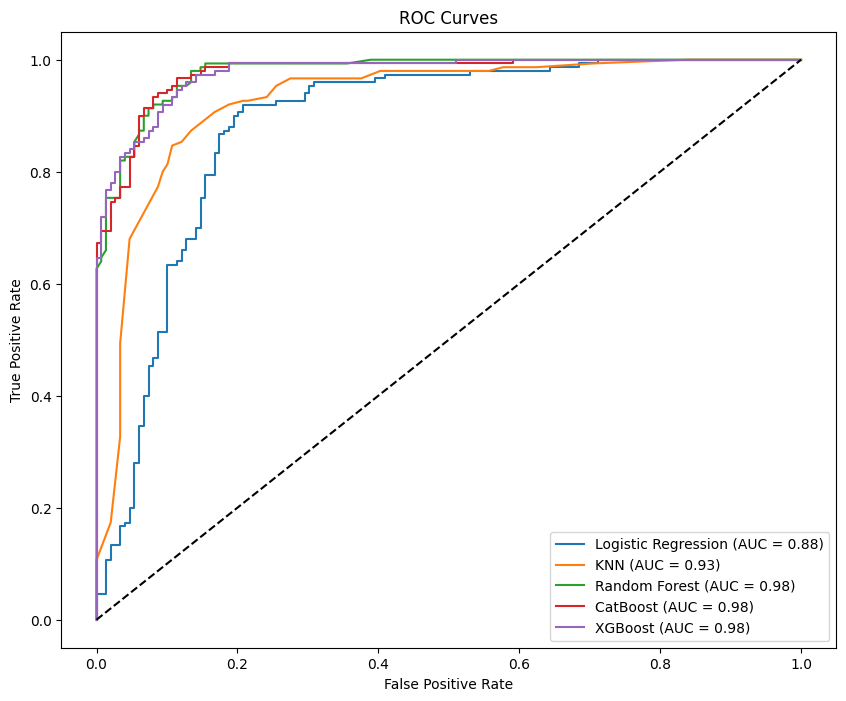

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# Assuming all models are defined and imported properly:
models = [
    {'label': 'LR', 'model': logreg},
    {'label': 'KNN', 'model': knn_model},
    {'label': 'XGBoost', 'model': xgb},
    {'label': 'RF', 'model': best_rf},
    {'label': 'GBDT', 'model': best_catboost_model}
]

means_roc = []
means_accuracy = []
means_f1 = []

# Fit, predict, and calculate ROC, accuracy, and F1 score for each model
for m in models:
    model = m['model']
    model.fit(X_train, y_train)

    # Accuracy calculation
    y_pred = model.predict(X_test)
    accuracy = 100 * round(metrics.accuracy_score(y_test, y_pred), 4)
    means_accuracy.append(accuracy)

    # ROC calculation
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_pred_proba = model.decision_function(X_test)
    else:
        y_pred_proba = y_pred  # Fallback for models without proba

    roc_auc = 100 * round(metrics.roc_auc_score(y_test, y_pred_proba), 4)
    means_roc.append(roc_auc)

    # F1 Score calculation
    try:
        f1_score_value = 100 * round(f1_score(y_test, y_pred, average='weighted'), 4)
    except ValueError:
        f1_score_value = None  # Handle cases where F1 score cannot be calculated
    means_f1.append(f1_score_value)

# Print calculated values for validation
print("Accuracy:", means_accuracy)
print("ROC AUC:", means_roc)
print("F1 Scores:", means_f1)

# Data for plotting
n_groups = len(models)
index = np.arange(n_groups)
bar_width = 0.25  # Adjusted for 3 bars

# Plotting the bars with higher contrast colors
fig, ax = plt.subplots(figsize=(14, 7))
rects1 = ax.bar(index, means_accuracy, bar_width, alpha=0.8, color='darkorange', label='Accuracy (%)')
rects2 = ax.bar(index + bar_width, means_roc, bar_width, alpha=0.8, color='navy', label='ROC (%)')
rects3 = ax.bar(index + 2 * bar_width, [f1 if f1 is not None else 0 for f1 in means_f1],
                bar_width, alpha=0.8, color='red', label='F1 Score (%)')

# Adding numeric labels on each bar
for rect in rects1:
    height = rect.get_height()
    ax.annotate(f'{height:.1f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, color='black')

for rect in rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.1f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, color='black')

for rect in rects3:
    height = rect.get_height()
    if height > 0:  # Avoid displaying '0' for models without an F1 score
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, color='black')

# Formatting the plot
plt.xlim([-1, n_groups])
plt.ylim([60, 100])
plt.title('Performance Evaluation - Diabetes Prediction', fontsize=14)
plt.xticks(index + bar_width, [m['label'] for m in models], rotation=40, ha='center', fontsize=12)
plt.legend(loc="upper right", fontsize=10)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xlabel('Models', fontsize=12)

# Save plot
plt.savefig("PE_diabetes_with_f1_labels.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

# Function to evaluate and plot ROC curve
def evaluate_and_plot_roc(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # ROC Curve
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_pred_proba = model.decision_function(X_test)
    else:
        y_pred_proba = y_pred  # Fallback for models without proba

    roc_auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # F1 Score calculation (make sure not to overwrite f1_score function)
    f1_score_value = f1_score(y_test, y_pred, average='weighted') * 100
    print(f"{model_name:<20} ROC AUC: {roc_auc:.2f}, F1-Score: {f1_score_value:.2f}")

    # Plot ROC curve
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Plotting ROC Curves for all models
plt.figure(figsize=(10, 8))
evaluate_and_plot_roc(logreg, X_train, y_train, X_test, y_test, "Logistic Regression")
evaluate_and_plot_roc(knn_model, X_train, y_train, X_test, y_test, "KNN")
evaluate_and_plot_roc(best_rf, X_train, y_train, X_test, y_test, "Random Forest")
evaluate_and_plot_roc(best_catboost_model, X_train, y_train, X_test, y_test, "CatBoost")
evaluate_and_plot_roc(xgb, X_train, y_train, X_test, y_test, "XGBoost")
plt.plot([0, 1], [0, 1], 'k--')  # Add diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()
